# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA) 
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets. 
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

Resizing the data by a factor 2 to make the computation of PCA faster.

In [81]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)
        # ----------------- Resizing images ------------------
        img = cv2.resize(img,(img.shape[1]//2,img.shape[0]//2))

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape, testFaces.shape)

(360, 56, 46) (360,) (40, 56, 46)


**Plotting faces and corrresponding faces from the train set**

Label -------------->  31


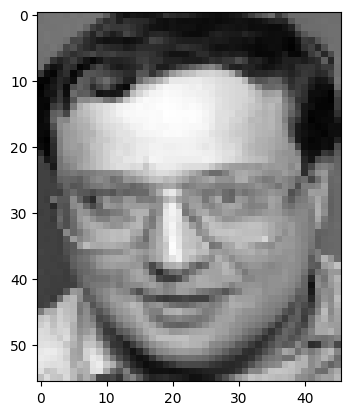

In [82]:
plt.imshow(trainFaces[2],cmap='gray')
print("Label --------------> ",trainLabels[2])

#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [83]:
def transform(X, mean, components):
    
    X_centered = X - mean
    X_transformed = X_centered.dot(components)
    return X_transformed

def PCA(X, numComponents):

    mean = np.mean(X, axis=0)
    X_centered = X - mean
    C = np.cov(X_centered.T)
    eigenvalues, eigenvectors = np.linalg.eig(C)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    eigenvalues = eigenvalues

    # Select the top numComponents eigenvectors
    if numComponents is not None:
        eigenvectors = eigenvectors[:, :numComponents]

    # Normalize the eigenvectors
    components = eigenvectors / np.linalg.norm(eigenvectors, axis=0, keepdims=True)

    return eigenvalues,mean,components

**Testing the Implemented PCA** 

In [84]:
X = np.random.randn(100, 5)
eigenvalues,mean,components = PCA(X, numComponents=2)
X_transformed = transform(X,mean,components)
X.shape, X_transformed.shape, eigenvalues

((100, 5),
 (100, 2),
 array([1.34144456, 1.1071306 , 0.92181855, 0.76637009, 0.65552413]))

##### Implementing on facial Images

In [85]:
faceshape = (trainFaces.shape[1], trainFaces.shape[2])
trainFaces1 = np.reshape(trainFaces, (trainFaces.shape[0],-1))
testFaces1 = np.reshape(testFaces, (testFaces.shape[0],-1))
print(f" Train Shape -- {trainFaces1.shape} -------------- Test Shape -- {testFaces1.shape}")

 Train Shape -- (360, 2576) -------------- Test Shape -- (40, 2576)


In [86]:
n_components = 256
eigenvalues,mean,components = PCA(trainFaces1, numComponents=n_components)

In [87]:
components.shape,eigenvalues.shape

((2576, 256), (2576,))

In [88]:
train_transformed = transform(trainFaces1,mean,components)
#test_transformed = transform(testFaces1,mean,components)
print(train_transformed.shape)

(360, 256)


##### ---------------- PCA from Sklearn to compare results

In [89]:
# from sklearn.decomposition import PCA
# from time import time
# n_components = 256
 
# t0 = time()
# pca = PCA(n_components = n_components, svd_solver ='randomized',
#           whiten = True).fit(trainFaces1)
# print("done in % 0.3fs" % (time() - t0))

# eigenfaces = pca.components_.reshape((n_components,56, 46))
 
# print("Projecting the input data on the eigenfaces orthonormal basis")
# t0 = time()
# X_train_pca = pca.transform(trainFaces1)
# pca.components_.shape
 


##### Visualizing Eigen Faces

In [90]:
c =components.T.real
eigenfaces1 = c.reshape((n_components,56, 46))
eigenfaces1.shape

(256, 56, 46)

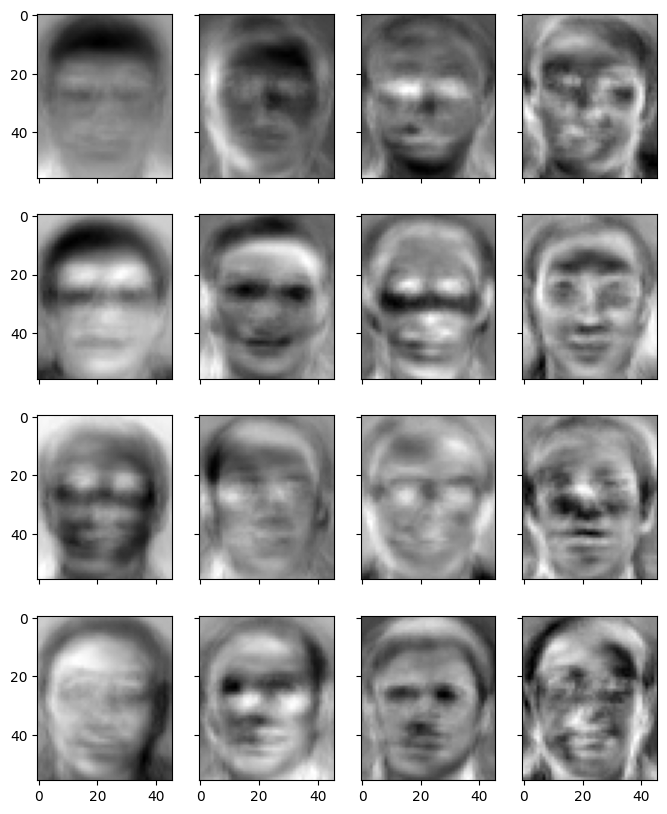

In [91]:
# Show the first 16 eigenfaces
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces1[i], cmap="gray")
plt.show()

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [92]:
def imageReconstruction(X_pca, eigenvectors, original_mean):

    reconstructed_images = np.dot(X_pca, eigenvectors.T) + original_mean
    return reconstructed_images


def visualize_reconstruction(original_images, reconstructed_images, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(6, 6))

    for i in range(num_samples):
        axes[i, 0].imshow(original_images[i].reshape(56, 46), cmap='gray')
        axes[i, 0].set_title('Original')

        axes[i, 1].imshow(reconstructed_images[i].reshape(56, 46), cmap='gray')
        axes[i, 1].set_title('Reconstructed')

    plt.tight_layout()
    plt.show()


In [93]:
train_transformed.shape

(360, 256)

In [94]:
train_reconstructed = imageReconstruction(train_transformed,components,mean)
train_reconstructed = train_reconstructed.real
train_reconstructed.shape

(360, 2576)

**Reconstructions for 256 principle components**

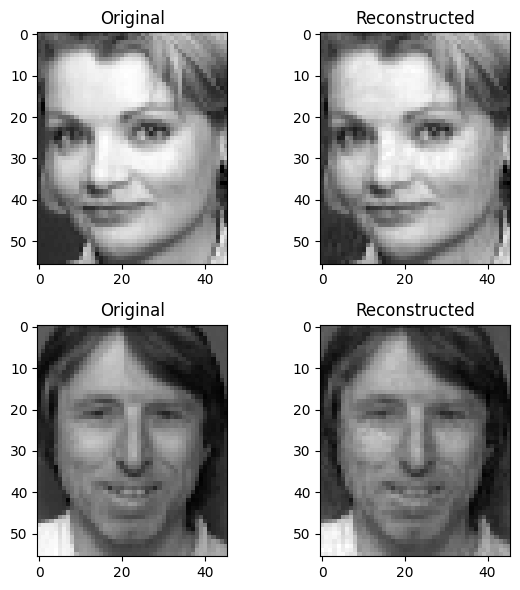

In [95]:
# plot recontructions here
visualize_reconstruction(trainFaces1, train_reconstructed,num_samples=2)

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

Principal Components = 5


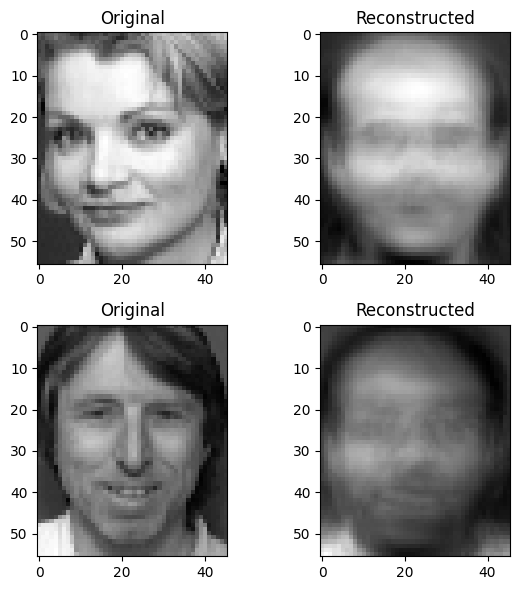

Principal Components = 10


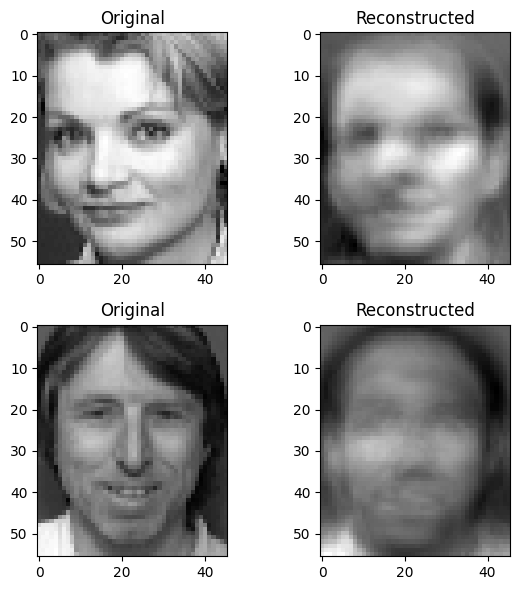

Principal Components = 50


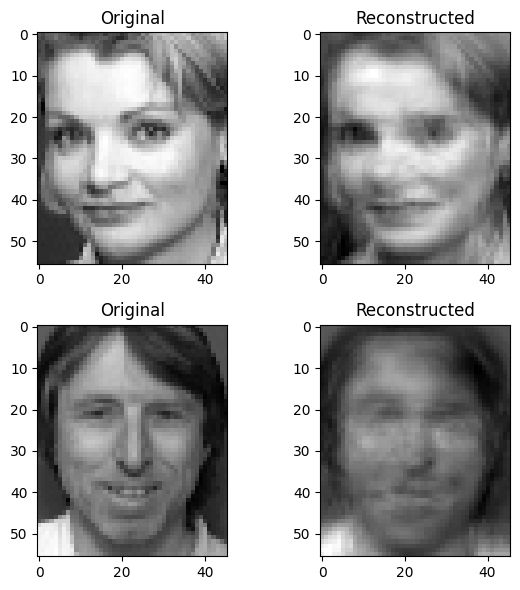

Principal Components = 100


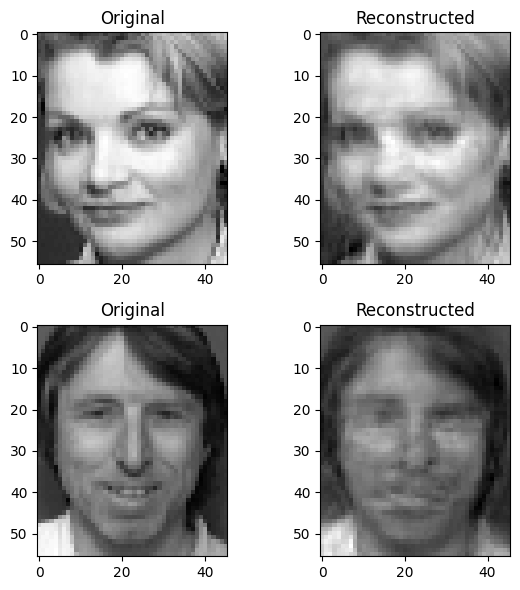

In [96]:
%matplotlib inline
def displayNfactors():
    for pc in [5, 10, 50, 100]:  
        train_transformed = transform(trainFaces1,mean,components[:,:pc])
        train_reconstructed = imageReconstruction(train_transformed,components[:,:pc],mean)
        train_reconstructed = train_reconstructed.real
        print(f"Principal Components = {pc}")
        visualize_reconstruction(trainFaces1, train_reconstructed,num_samples=2)
displayNfactors()

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them. 
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations. 
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [97]:
testFaces1[1].shape

(2576,)

In [99]:
def getClass(testFaces,eigenFaces, meanFace,X_train,y_train):
    """
    Arguments:
    1. Test image
    2. Eigenvectors
    3. Mean Eigen Face
    4. Training Set(X_train,y_train)

    The function must return the following:
    1. image with smallest error
    2. error value
    3. prediction class
    """

    test_transformed = transform(testFaces,meanFace,eigenFaces)
    train_transformed = transform(trainFaces1,meanFace,eigenFaces)
    images,error,prediction = [], [], []
    for test_index in range(testFaces.shape[0]):
        a = (train_transformed - test_transformed[test_index])
        euclidean_distance = np.linalg.norm(a, axis=1)
        best_match = np.argmin(euclidean_distance)
        images.append(X_train[best_match])
        error.append(euclidean_distance[best_match])
        prediction.append(y_train[best_match])


    return np.array(images), np.array(error), np.array(prediction)

Iterate through all the images in the test data and test the accuracy by taking different number of components

In [103]:
components1 = [3,5,10,20,30,40,50]
mse = []
msle = []
accuracy_list = []
for numComponents in components1:
    pred_image,error,prediction = getClass(testFaces1, components[:,:numComponents], mean, trainFaces1,trainLabels)
    accuracy = np.sum(testLabels==prediction) / testLabels.shape
    accuracy_list.append(accuracy[0])
    mse_loss = (np.square(testFaces1 - pred_image)).mean(axis=1).mean(axis=0)
    mse.append(mse_loss)
    msle_loss = np.mean((np.log1p(testFaces1) - np.log1p(pred_image))**2)
    msle.append(msle_loss)


Plot Number of eigenvectors vs Mean Square Error

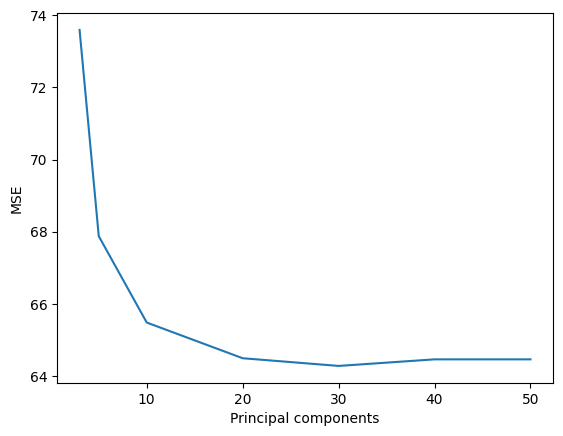

In [107]:
# your code here
plt.plot(components1,mse)
plt.ylabel("MSE")
plt.xlabel("Principal components")
plt.show()

Plot Number of eigenvectors vs Logarithmic Mean Square Error

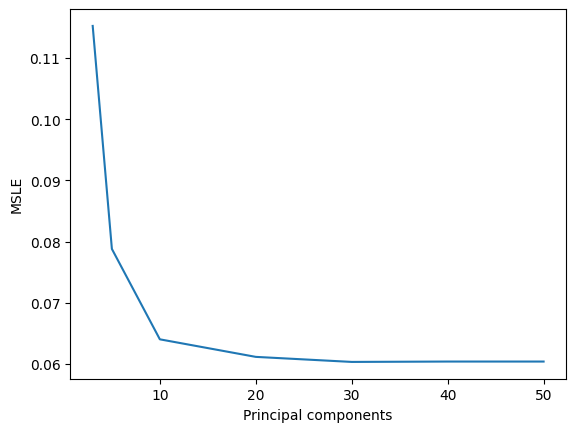

In [106]:
# your code here
plt.plot(components1,msle)
plt.ylabel("MSLE")
plt.xlabel("Principal components")
plt.show()

**Accuracy Plot**

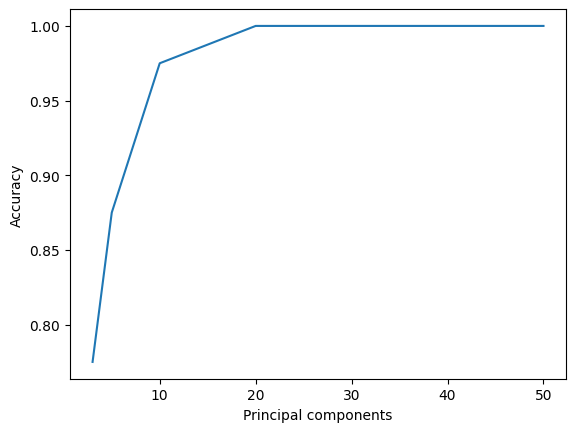

In [109]:
plt.plot(components1,accuracy_list)
plt.ylabel("Accuracy")
plt.xlabel("Principal components")
plt.show()